In [1]:
import rasterio
from rasterio.transform import Affine
import numpy as np
import os
import matplotlib.pyplot as plt
from rasterio.plot import show

In [8]:
#defining the path for raster files and opening them
B05_2019= rasterio.open('LC08_L1TP_029047_20190203_20190206_01_T1_B5_clip.tif')
B04_2019= rasterio.open('LC08_L1TP_029047_20190203_20190206_01_T1_B4_clip.tif')
B04_2014= rasterio.open('LC08_L1TP_029047_20140205_20170307_01_T1_B4_clip.tif')
B05_2014= rasterio.open('LC08_L1TP_029047_20140205_20170307_01_T1_B5_clip.tif')

In [9]:
B05_2019.read()

array([[[    0, 15510, 14779, ..., 18204, 18722, 18515],
        [    0, 11765, 13832, ..., 15842, 16966, 17672],
        [    0, 10027, 11470, ..., 14321, 14948, 15572],
        ...,
        [    0, 14584, 13352, ..., 15260, 14624, 13359],
        [    0, 14569, 13616, ..., 15065, 13242, 11065],
        [    0,     0,     0, ...,     0,     0,     0]]], dtype=uint16)

In [17]:
#reading bands as matrix array
B4_2019_data= B04_2019.read(1)
B5_2019_data= B05_2019.read(1)
B5_2014_data= B05_2014.read(1)
B4_2014_data= B04_2014.read(1)

In [12]:
#checking projection system of our datasets
B04_2014.crs

CRS.from_epsg(32613)

In [13]:
B04_2019.crs

CRS.from_epsg(32613)

In [14]:
#chechking the shape of our datasets
B04_2019.shape


(610, 597)

In [15]:
B04_2014.shape


(610, 597)

In [16]:
#checking geotransformation parameters of our datasets
print(B04_2019.get_transform())
print(B04_2014.get_transform())

[652500.0, 29.98324958123953, 0.0, 2166000.0, 0.0, -30.0]
[652500.0, 29.98324958123953, 0.0, 2166000.0, 0.0, -30.0]


In [19]:
#defining parameters for our new raster dataser
cols= B04_2014.width
rows=B04_2014.height
transform= B04_2019.transform
projection= B04_2019.crs

In [22]:
#Calculating NDVI for 2014 and 2019
NDVI_2014 = np.divide(B5_2014_data - B4_2014_data, B5_2014_data + B4_2014_data,where=(B5_2014_data - B4_2014_data)!=0)
NDVI_2014[NDVI_2014>1] = 1
NDVI_2019 = np.divide(B5_2019_data - B4_2019_data, B5_2019_data + B4_2019_data,where=(B5_2019_data - B4_2019_data)!=0)
NDVI_2019[NDVI_2019>1]= 1

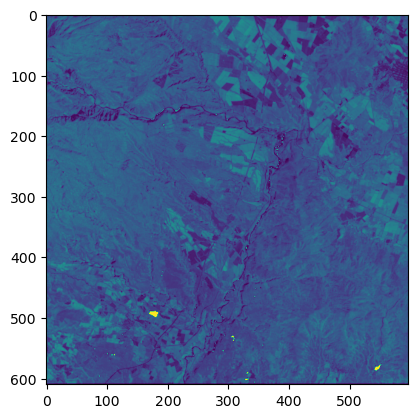

In [23]:
plt.imshow(NDVI_2014)

In [28]:
#Saving the generated NDVI rasters
def saveRaster(dataset,datasetPath,cols,rows,projection):
    rasterSet = rasterio.open(datasetPath,
                             'w',
                             driver='GTiff',
                             height=rows,
                             width=cols,
                             count=1,
                             dtype=np.float32,
                             crs=projection,
                             transform=transform,)
    rasterSet.write(dataset,1)
    rasterSet.close()
saveRaster(NDVI_2014.astype('float32'),'NDVI_2014.tif',cols,rows,projection)
saveRaster(NDVI_2019.astype('float32'),'NDVI_2019.tif',cols,rows,projection)

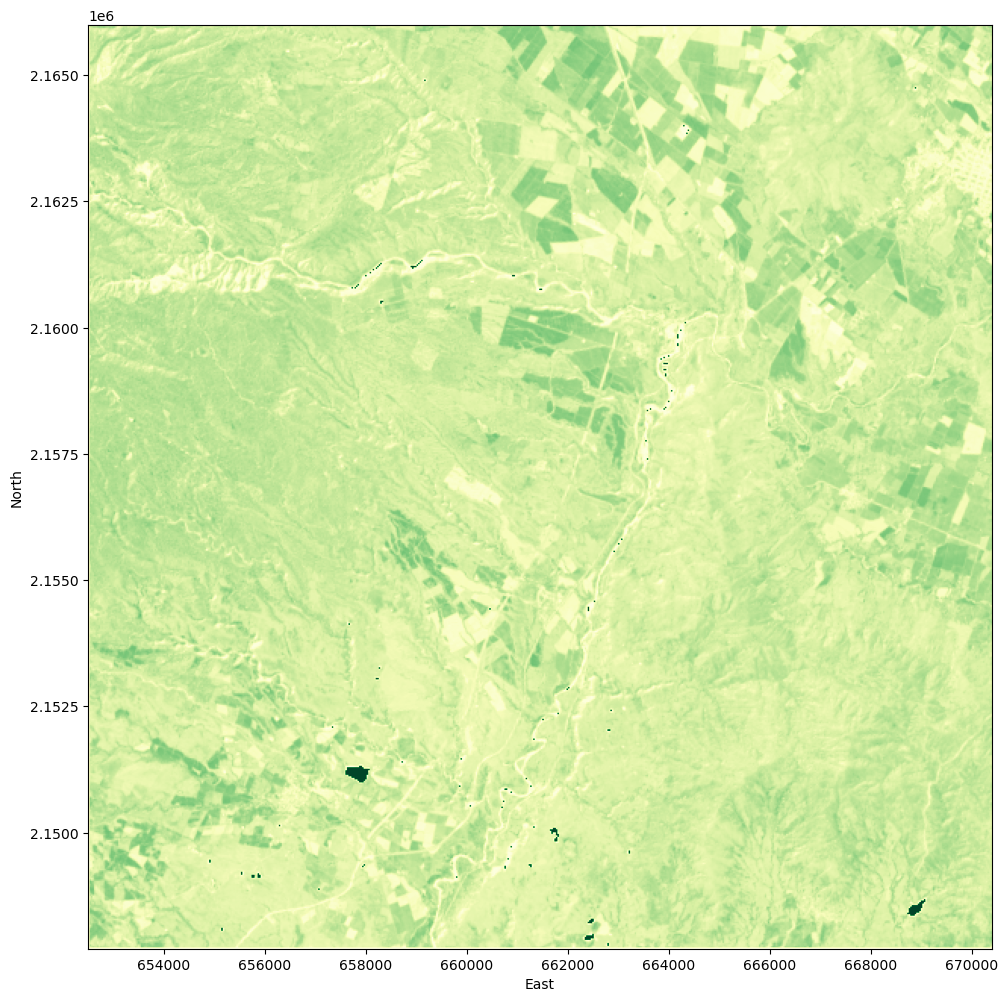

In [30]:
#plotting the NDVI Images with a colorbar
def plotNDVI(ndviImage,cmap):
    src = rasterio.open(ndviImage,'r')
    fig, ax = plt.subplots(1, figsize=(12, 12))
    show(src, cmap=cmap, ax=ax)
    ax.set_xlabel('East')
    ax.set_ylabel('North')
    plt.show()
plotNDVI('NDVI_2014.tif','YlGn')



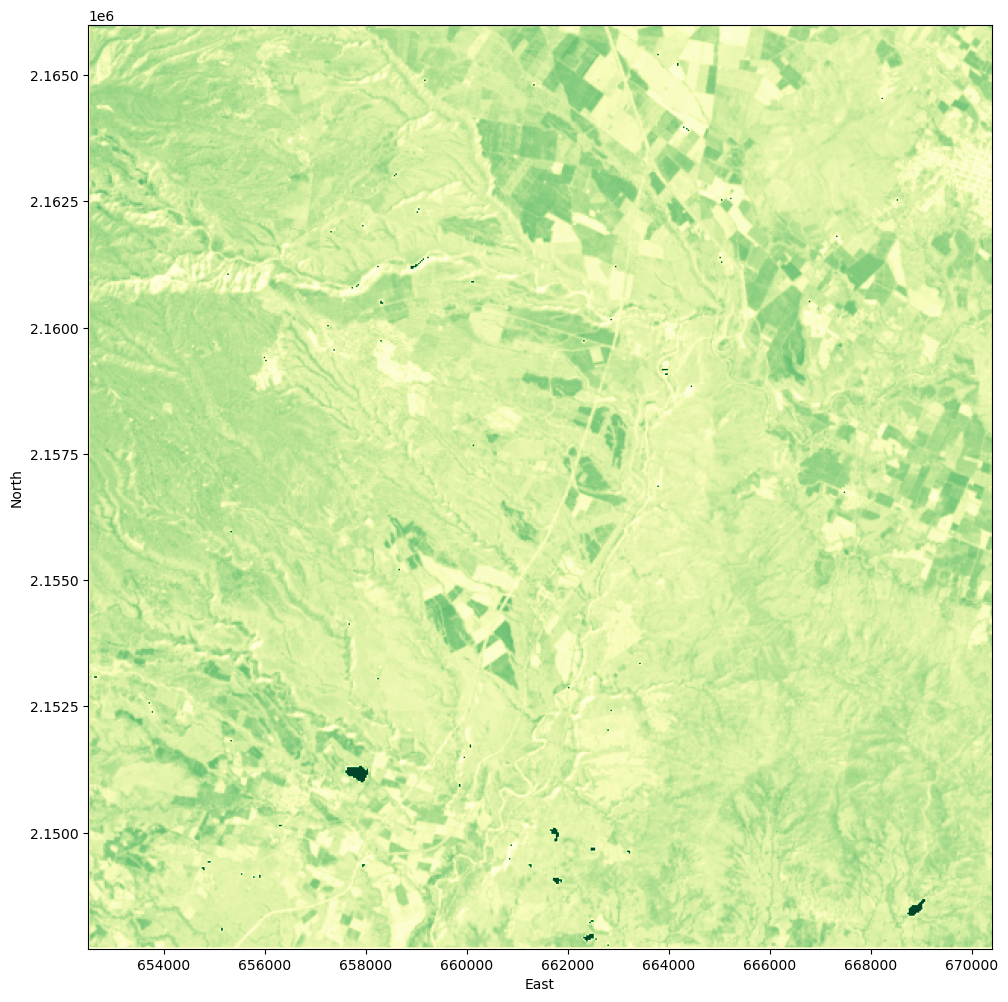

In [31]:
plotNDVI('NDVI_2019.tif','YlGn')

In [33]:
#Creating a land cover change map
NDVI_Change= NDVI_2019-NDVI_2014
NDVI_Change= np.where((NDVI_2014>-999)& (NDVI_2019>-999), NDVI_Change,-999 )


In [34]:
NDVI_Change

array([[ 0.        ,  0.03547079,  0.03795126, ...,  0.03159038,
         0.03800274,  0.02669263],
       [ 0.        ,  0.03765402,  0.05892348, ..., -0.00586917,
         0.01892243,  0.0195063 ],
       [ 0.        ,  0.03218401,  0.03739506, ..., -0.06377307,
        -0.0306757 ,  0.03894268],
       ...,
       [ 0.        , -0.01659706,  0.01140219, ...,  0.00272184,
         0.02552676,  0.06663901],
       [ 0.        ,  0.00599447, -0.00407705, ...,  0.05750174,
         0.00467577,  0.08448431],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [35]:
#Saving the generated Change Raster
saveRaster(NDVI_Change.astype('float32'),'NDVI_Change.tif',cols,rows,projection)

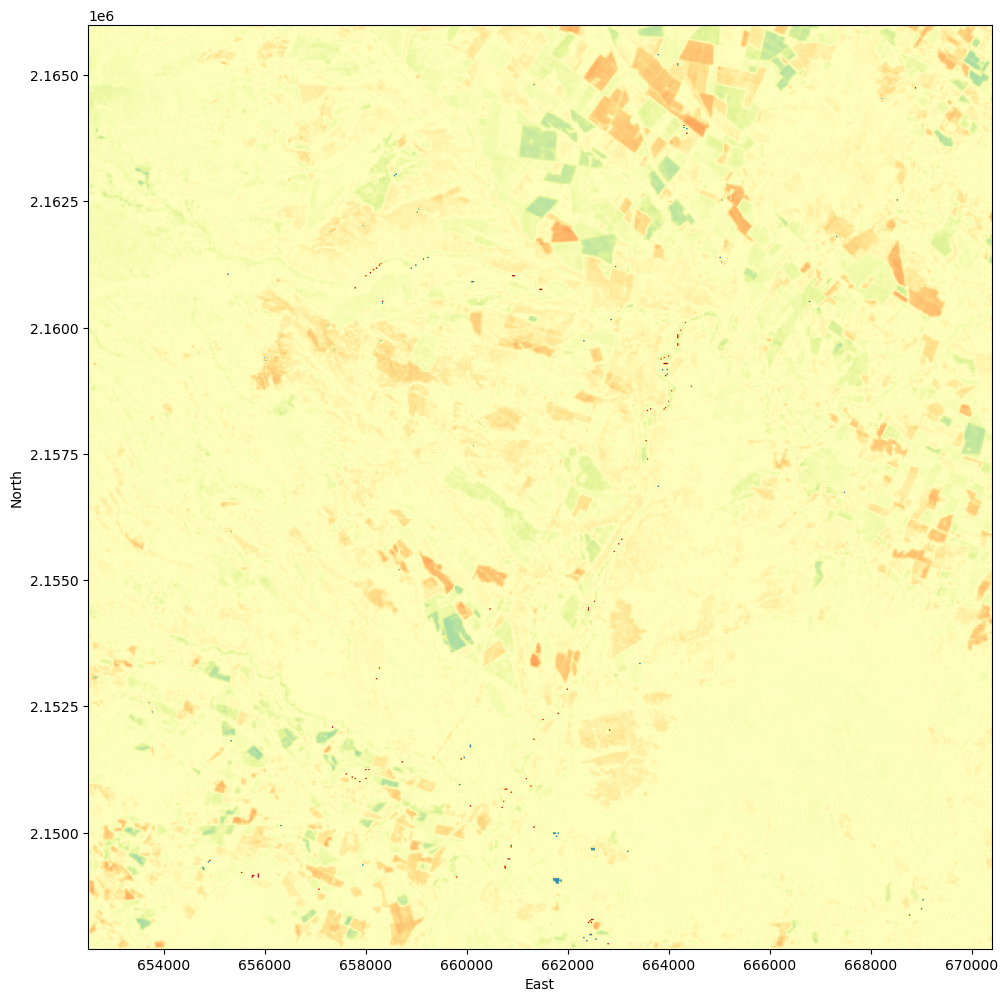

In [36]:
#Plotting the Land cover change map with color bar 
plotNDVI('NDVI_Change.tif','Spectral')